In [1]:
from matplotlib import cm
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import skimage
from skimage.feature import canny
from skimage import data

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib notebook

In [2]:
def PrepareCrossSections2(image):
    sr = 10 # start row
    jump = 40
    sw = 3 # section winow width
    row1, col1 = image.shape
    linds = np.where(image==1)
    rinds = linds[0]
    cinds = linds[1]
    pdist = np.multiply(rinds,rinds) + np.multiply(cinds,cinds)
    pargs = np.argsort(pdist)
    
    temp = np.arange(sr,pargs.shape[0],jump)
    cross_image = np.zeros((row1,col1,temp.shape[0])) # store each cross section separately
    ctr = 0
    for p in range(sr,pargs.shape[0],jump):
        cur_image = np.zeros((row1,col1))
        i = rinds[pargs[p]]
        j = cinds[pargs[p]]
        cur_image[i-sw:i+sw,j-sw:j+sw] = image[i-sw:i+sw,j-sw:j+sw]
        # i,j is the pixel through which cross section should pass
        
        h, theta, d = hough_line(cur_image,theta=np.arange(-np.pi/2,np.pi/2,np.pi/360))

        for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=1,min_angle=1,threshold=0.99*np.max(h))):

            if angle>np.pi/2:
                angle = angle - np.pi/2
            else:
                angle = angle + np.pi/2

            dist = j*np.cos(angle)*1.0 + i*np.sin(angle)*1.0


            lin_image = np.zeros((row1,col1))
            # burning the line
            klist = np.arange(0,col1,0.1)
            for k in klist:
                y1 = (dist - k * np.cos(angle)) / np.sin(angle)
                y1_int = int(np.round(y1))
                k_int = int(np.round(k))
                if y1_int>=0 and y1_int<row1 and k_int>=0 and k_int<col1:
                    lin_image[y1_int,k_int] = 1
            
            # use the cross section if it passes the current center line pixel
            # exit after finding the first such cross section
            if lin_image[i,j]>0:
                lin_image = skimage.morphology.skeletonize(lin_image)
                cross_image[:,:,ctr] = lin_image
                ctr = ctr + 1
                break
    
    return cross_image


        

<IPython.core.display.Javascript object>


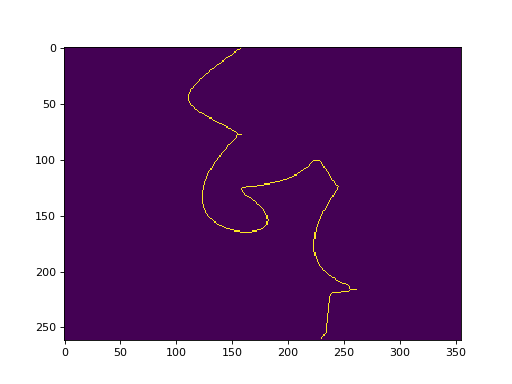

<IPython.core.display.Javascript object>


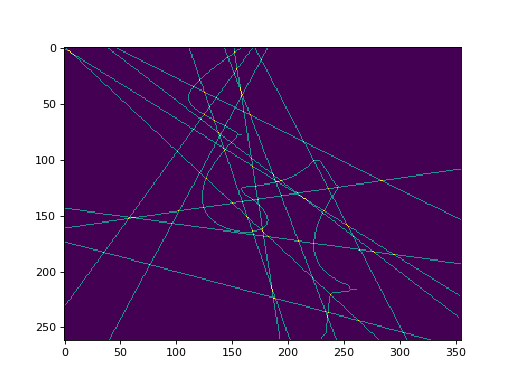

In [113]:
# Constructing test image.
image = Image.open('CenterLine-Example4.png')
image = np.array(image)[:,:,0]
image[image>0] = 1
image = skimage.morphology.skeletonize(image)
plt.figure()
plt.imshow(image)
cross_images = PrepareCrossSections2(image)

cross_sum = np.sum(cross_images,axis=2)
plt.figure()
plt.imshow(image+cross_sum)
 

In [ ]:
row1, col1 = image.shape
temp = np.arange(10,row1,20)
cross_image = np.zeros((row1,col1,temp.shape[0]))
ctr = 0
for i in range(10,row1,20):
    cur_image = np.zeros((row1,col1))
    cur_image[i-3:i+3] = image[i-3:i+3]
    cur_vec = image[i,:]
    j = np.where(cur_vec==1)[0][0]
    h, theta, d = hough_line(cur_image,theta=np.arange(-np.pi/2,np.pi/2,np.pi/360))

    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(6, 12))
    plt.tight_layout()

    ax0.imshow(cur_image, cmap=cm.gray)
    ax0.set_title('Input image')
    ax0.set_axis_off()

    ax2.imshow(cur_image, cmap=cm.gray)
    
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=1,min_angle=1,threshold=0.99*np.max(h))):
        
        if angle>np.pi/2:
            angle = angle - np.pi/2
        else:
            angle = angle + np.pi/2
        
        dist = j*np.cos(angle) + i*np.sin(angle)
        
        
        lin_image = np.zeros((row1,col1))
        for k in range(0,col1):
            y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
            y1 = (dist - k * np.cos(angle)) / np.sin(angle)
            y1_int = int(np.round(y1))
            if y1_int>=0 and y1_int<row1:
                lin_image[y1_int,k] = 1
        if lin_image[i,j]>0:
            cross_image[:,:,ctr] = lin_image
            ctr = ctr + 1
            ax2.plot((0, k), (y0, y1), '-r')
            break
        ax2.plot((0, k), (y0, y1), '-r')
#         lin_image[np.logical_and(image==0,lin_image!=5)] = 0
    #     lin_image[sum(rinds)/len(rinds),sum(cinds)/len(cinds)]=5

    #     print sum(rinds)/len(rinds),sum(cinds)/len(cinds)


    #     break
    ax2.axis((0, col1, row1, 0))
    ax2.set_title('Detected lines')
    ax2.set_axis_off()
    ax1.imshow(cross_image[:,:,0], cmap=cm.gray)
    

In [60]:
temp = np.array([[1, 0, 1],[0, 1,0],[0, 0, 1]])
linds = np.where(temp==1)
rinds = linds[0]
cinds = linds[1]
pdist = np.multiply(rinds,rinds) + np.multiply(cinds,cinds)
pargs = np.argsort(pdist)
print pdist,pargs,pargs.shape[0]

[0 4 2 8] [0 2 1 3] 4


In [24]:
import os
import sys
import numpy as np
import skimage
import skimage.measure
import skimage.morphology
import glob
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import matplotlib.pyplot as plt
sys.path.append('/home/kumarv/khand035/.conda/envs/gdalenv/lib/python2.7/site-packages/')
from osgeo import gdal,ogr

def RecoverLabels(pmasks,masks,emask):
    rows,cols,numt = masks.shape
   
    for i in range(0,numt):
        cur_mask = masks[:,:,i].copy()
        cur_pmask = pmasks[:,:,i].copy()
        cur_pmask[emask] = cur_mask[emask]
        pmasks[:,:,i] = cur_pmask

    return pmasks

def SelectLargestComponent(masks):
    rows,cols,numt = masks.shape
    new_masks = np.zeros((rows,cols,numt))
    
    for i in range(0,numt):
        cur_mask = masks[:,:,i]==1
        cur_labels = skimage.measure.label(cur_mask,background=0)
#         if i ==0:
#             f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True,figsize=(15,10))
#             ax1.imshow(cur_mask)
#             ax2.imshow(cur_labels)
            
#             temp = np.bincount(cur_labels.flatten())
#             print temp
        
        if np.max(cur_labels)==0:
            lcc=-2
        else:
            lcc = np.argmax(np.bincount(cur_labels.flatten())[1:])
        
        new_mask = cur_labels==lcc+1
        new_mask = new_mask.astype('int')
        new_mask[masks[:,:,i]>1] = 2
        new_masks[:,:,i] = new_mask
        
    return new_masks

def pix2coord(x,y,image):
    ds = gdal.Open(image,0)
    # GDAL affine transform parameters, According to gdal documentation xoff/yoff are image left corner, a/e are pixel wight/height and b/d is rotation and is zero if image is north up. 
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()

    """Returns global coordinates from pixel x, y coords"""
    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff
    return(xp, yp)


def PrepareCrossSections2(image,geobase):
    sr = 5 # start row
    jump = 5
    sw = 1 # section winow width
    row1, col1 = image.shape
    linds = np.where(image==1)
    rinds = linds[0]
    cinds = linds[1]
    pdist = np.multiply(rinds,rinds) + np.multiply(cinds,cinds)
    pargs = np.argsort(pdist)
    
    temp = np.arange(sr,pargs.shape[0],jump)
    cross_image = np.zeros((row1,col1,temp.shape[0])) # store each cross section separately
    coord_info = np.zeros((temp.shape[0],2)) # store each cross section separately
    
    ctr = 0
    for p in range(sr,pargs.shape[0],jump):
        cur_image = np.zeros((row1,col1))
        i = rinds[pargs[p]]
        j = cinds[pargs[p]]
        clat,clon = pix2coord(i,j,geobase)
        cur_image[i-sw:i+sw,j-sw:j+sw] = image[i-sw:i+sw,j-sw:j+sw]
        # i,j is the pixel through which cross section should pass
        
        h, theta, d = hough_line(cur_image,theta=np.arange(-np.pi/2,np.pi/2,np.pi/360))

        for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=1,min_angle=1,threshold=0.99*np.max(h))):

            if angle>np.pi/2:
                angle = angle - np.pi/2
            else:
                angle = angle + np.pi/2

            dist = j*np.cos(angle)*1.0 + i*np.sin(angle)*1.0


            lin_image = np.zeros((row1,col1))
            # burning the line
            klist = np.arange(0,col1,0.1)
            for k in klist:
                y1 = (dist - k * np.cos(angle)) / np.sin(angle)
                y1_int = int(np.round(y1))
                k_int = int(np.round(k))
                if y1_int>=0 and y1_int<row1 and k_int>=0 and k_int<col1:
                    lin_image[y1_int,k_int] = 1
            
            # use the cross section if it passes the current center line pixel
            # exit after finding the first such cross section
            if lin_image[i,j]>0:
                lin_image = skimage.morphology.skeletonize(lin_image)
                cross_image[:,:,ctr] = lin_image
                coord_info[ctr,0] = clat
                coord_info[ctr,1] = clon
                ctr = ctr + 1
                break
    
    return cross_image,coord_info

def GetCrossSectionProfiles(csec,cline,lmask,delv):
    linds = np.where(csec==1)
    rinds = linds[0]
    cinds = linds[1]
    pdist = np.multiply(rinds,rinds) + np.multiply(cinds,cinds)
    pargs = np.argsort(pdist)
    
    temp = np.arange(0,pargs.shape[0])
    labp = np.zeros((temp.shape[0],))
    elep = np.zeros((temp.shape[0],))
    ctr = 0
    for p in range(0,temp.shape[0]):
        i = rinds[pargs[p]]
        j = cinds[pargs[p]]
        labp[p] = lmask[i,j]
        elep[p] = delv[i,j]
        if cline[i,j]==1:
            labp[p] = 2
        
    return labp,elep

    

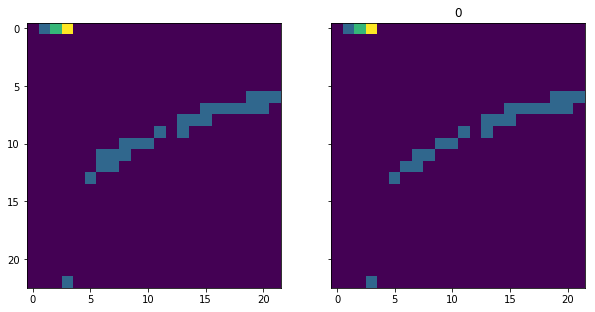

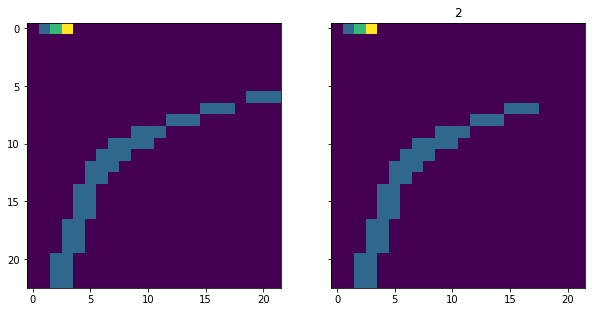

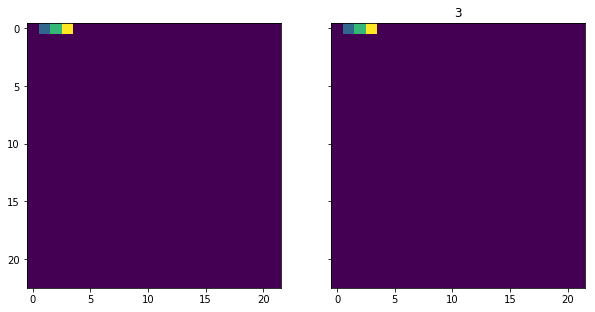

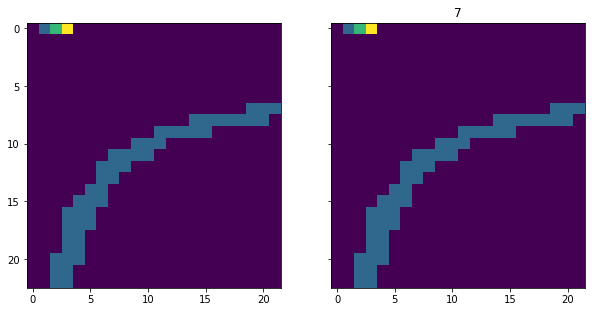

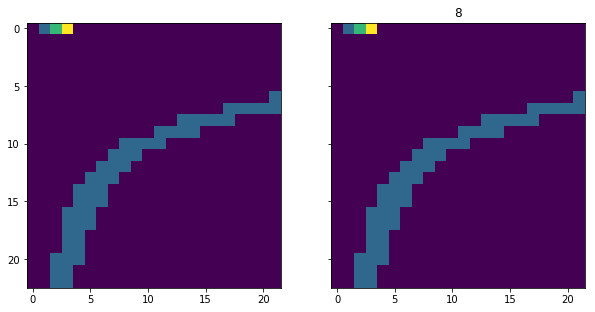

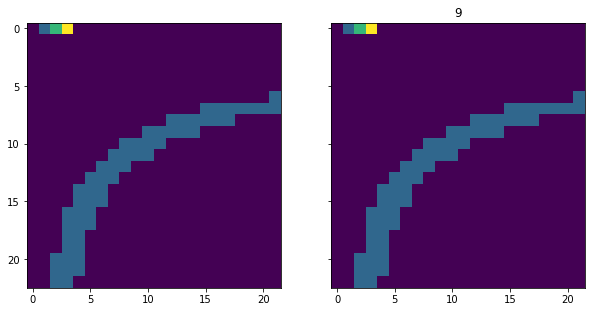

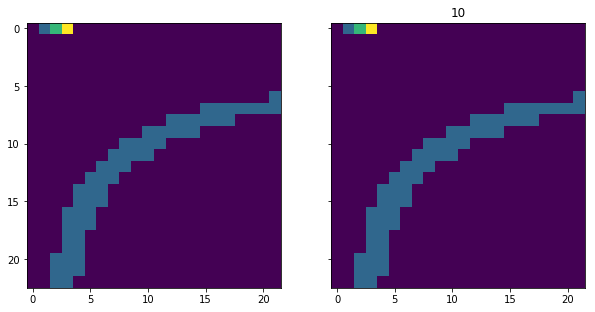

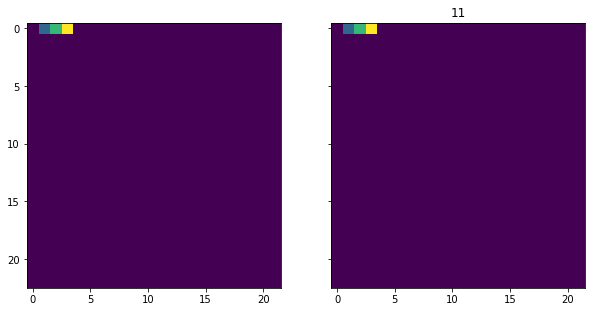

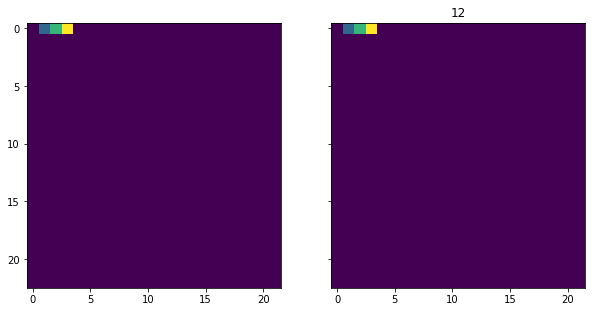

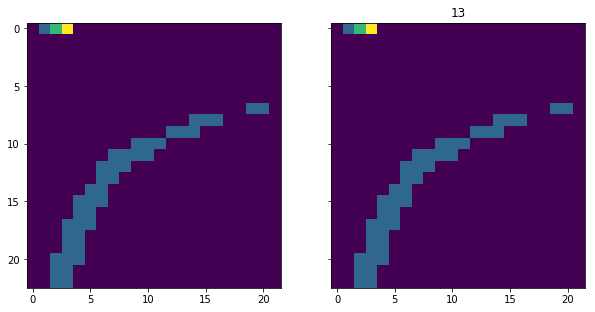

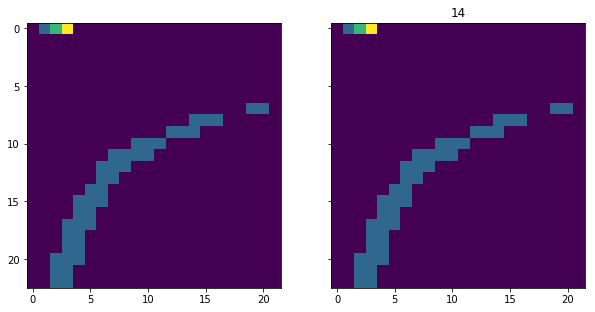

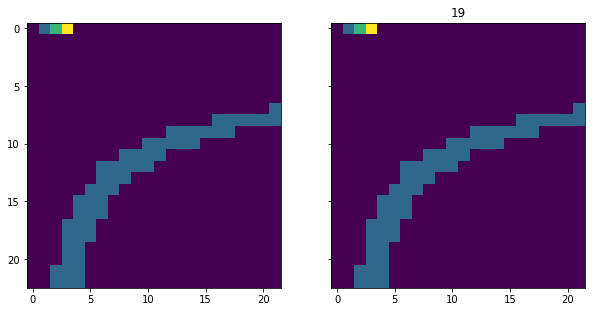

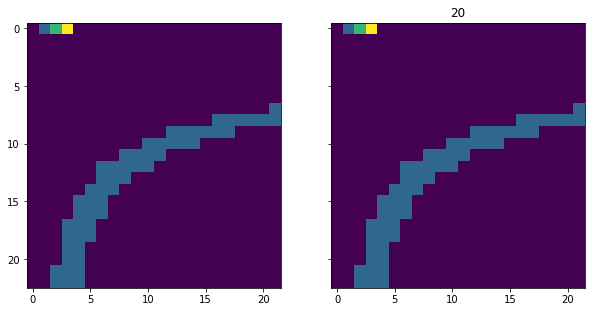

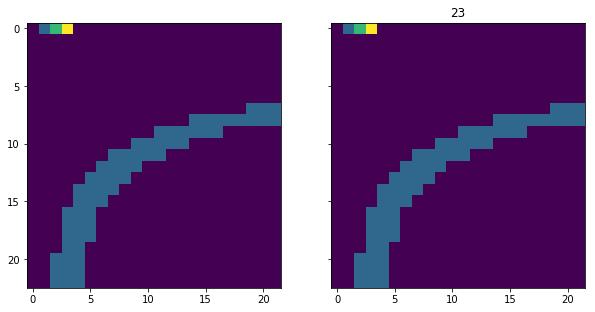

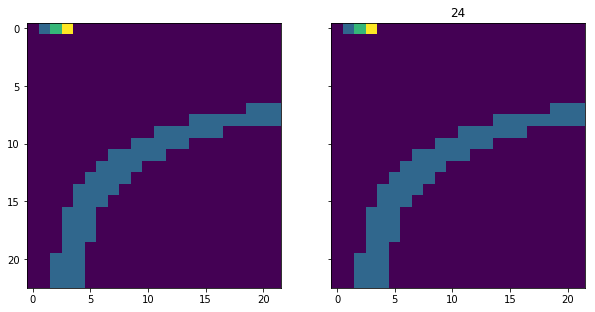

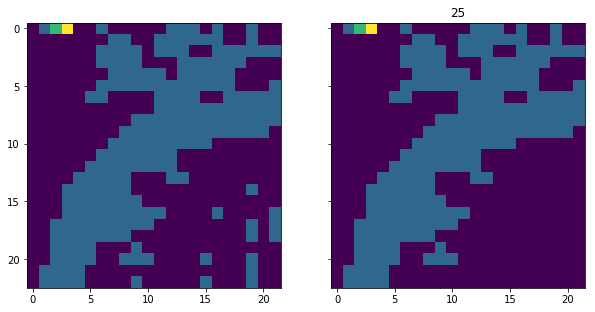

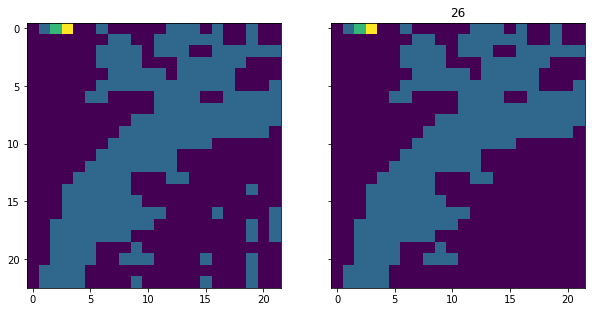

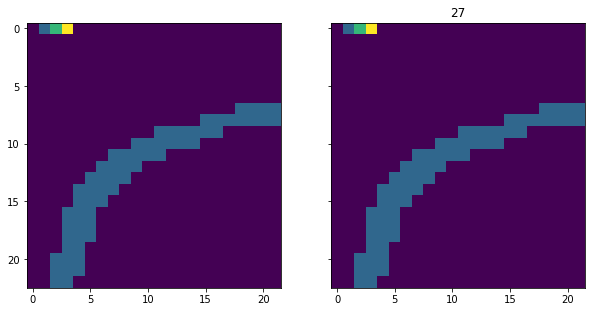

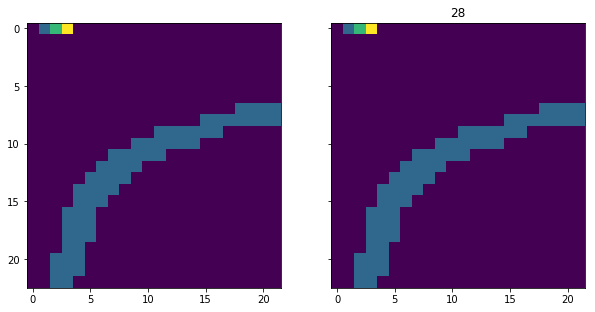

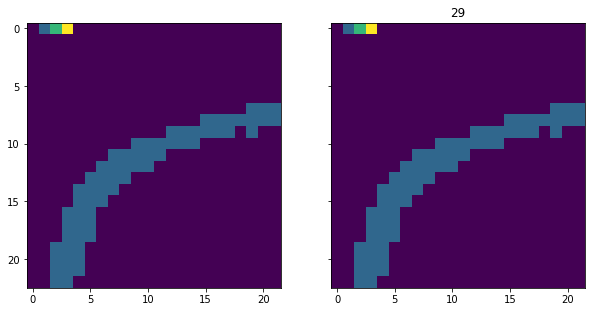

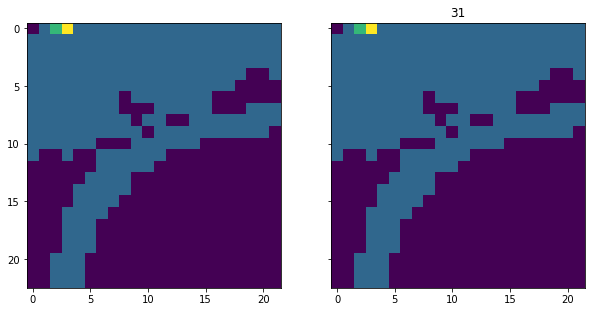

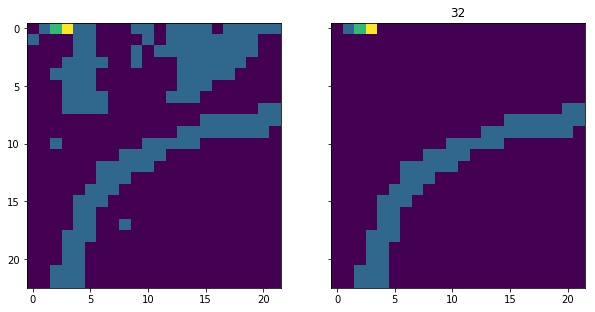

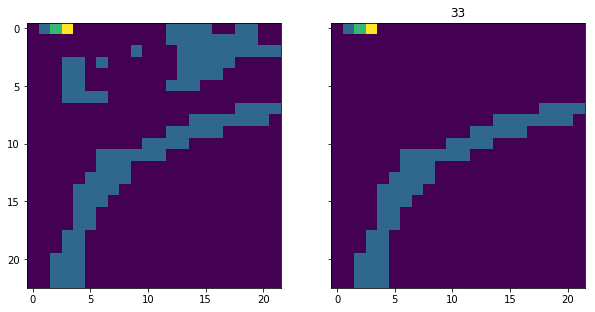

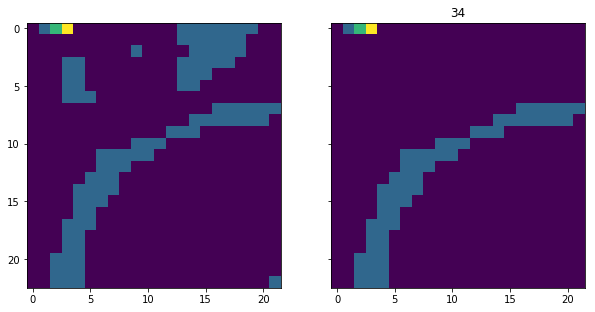

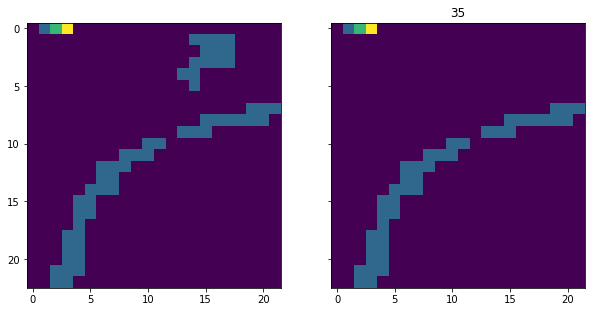

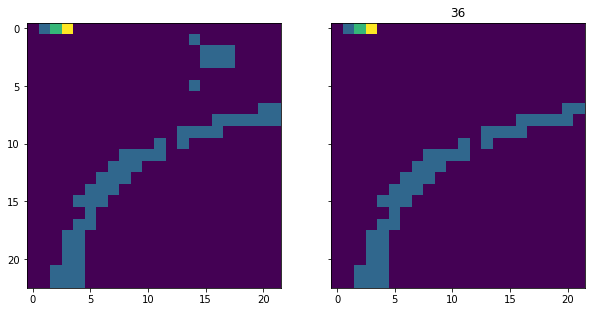

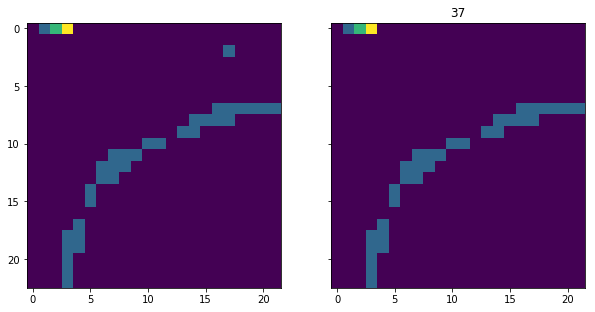

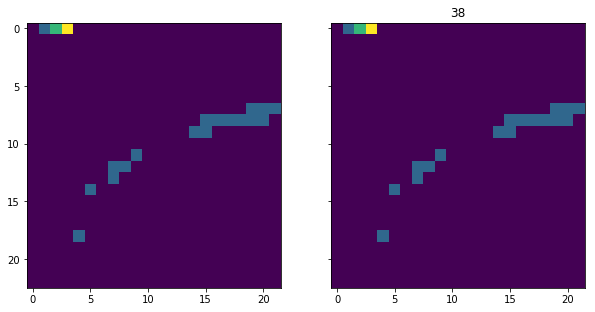

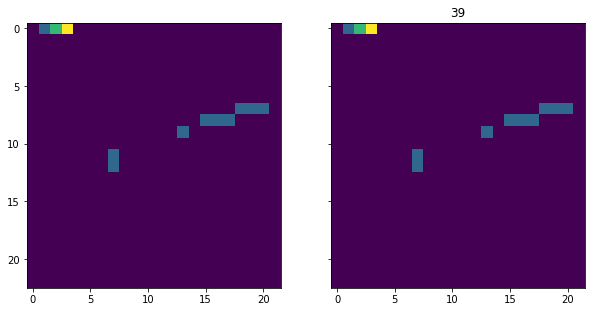

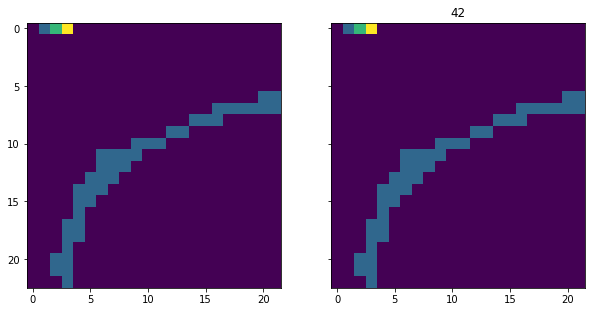

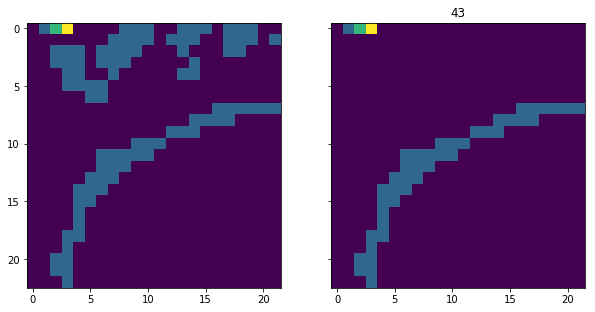

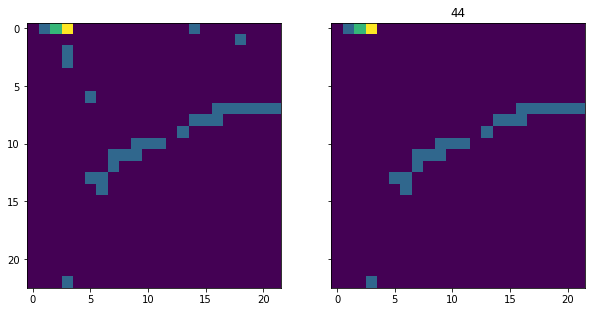

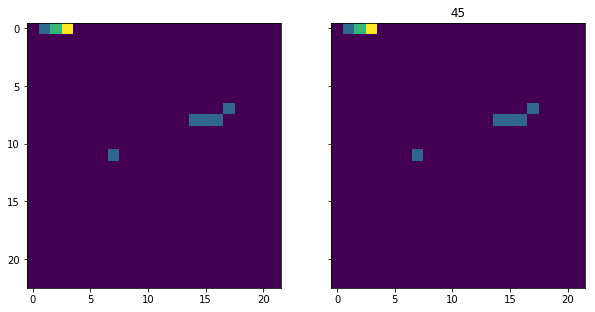

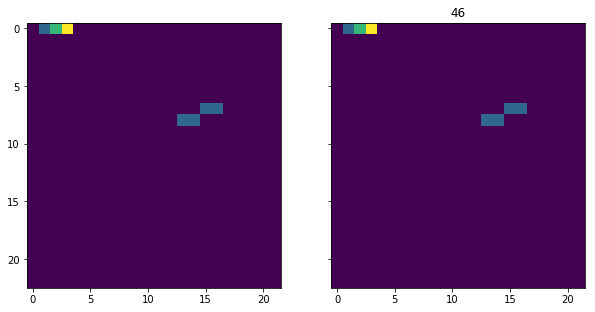

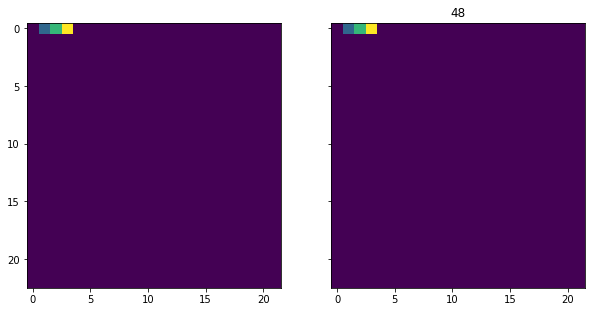

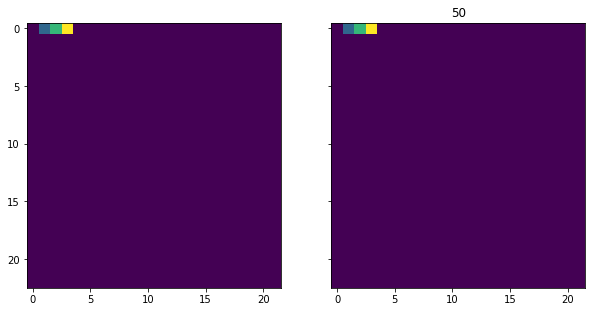

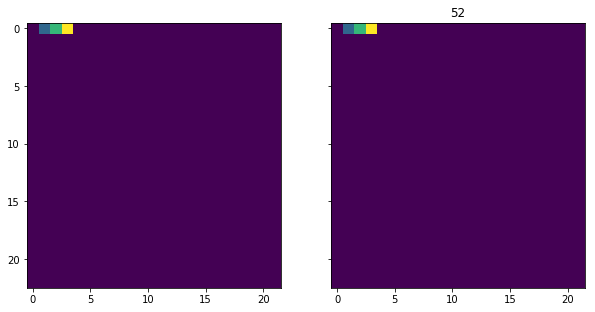

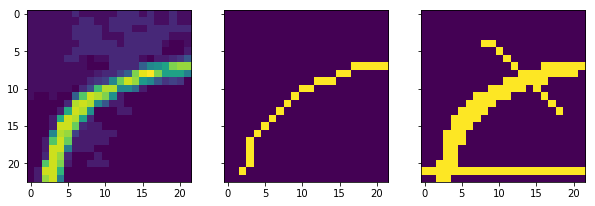

In [25]:
data_dir = '/home/kumarv/khand035/Projects/MINT/river-depth-estimation/data/BIDS2114-2/'
flag = 0
mask_list = glob.glob(data_dir + 'M2*.tif')
%matplotlib inline
for filename in glob.glob(data_dir + 'M2*.tif'):
    #print filename
    ds = gdal.Open(filename)
    numchannels = ds.RasterCount
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    mask_arr = np.array(ds.GetRasterBand(1).ReadAsArray())
    if flag==0:
        masks = np.zeros((rows,cols,len(mask_list)))
    masks[:,:,flag] = mask_arr
    flag = flag + 1

pmasks = SelectLargestComponent(masks)


nmask = np.sum(pmasks==1,axis=2)*1.0
dmask = np.sum(pmasks<=1,axis=2)*1.0
emask = np.divide(nmask,dmask)>0.3
pmasks = RecoverLabels(pmasks,masks,emask)

for i in range(0,pmasks.shape[2]):
        
        cur_mask = masks[:,:,i].copy()
        cur_pmask = pmasks[:,:,i].copy()
        if np.sum(cur_mask>1)*1.0/(cur_mask.shape[0]*cur_mask.shape[1])>0:
            continue
        f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True,figsize=(10,5))
        cur_mask[0,0] = 0
        cur_mask[0,1] = 1
        cur_mask[0,2] = 2
        cur_mask[0,3] = 3
        
        cur_pmask[0,0] = 0
        cur_pmask[0,1] = 1
        cur_pmask[0,2] = 2
        cur_pmask[0,3] = 3
        
        ax1.imshow(cur_mask)
        ax2.imshow(cur_pmask)
        plt.title(str(i))

        
cline = skimage.morphology.skeletonize(emask)
csecs,ccord = PrepareCrossSections2(cline,data_dir + 'dem.tiff')

f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True,figsize=(10,5))
ax1.imshow(np.divide(nmask,dmask))
ax2.imshow(cline)
temp = emask.copy()
temp[np.sum(csecs[:,:,0:-1],axis=2)>0] = 2
ax3.imshow(temp)
plt.show()

ds = gdal.Open(data_dir + 'dem.tiff')
delv = np.array(ds.GetRasterBand(1).ReadAsArray())

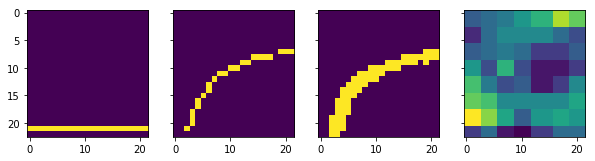

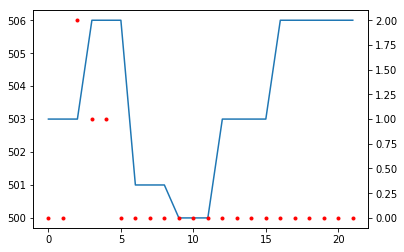

In [16]:
cur_sec = csecs[:,:,2]
cur_mask = pmasks[:,:,29]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, sharex=True, sharey=True,figsize=(10,5))
ax1.imshow(cur_sec)
ax2.imshow(cline)
ax3.imshow(cur_mask)
ax4.imshow(delv)
plt.show()

labp,elvp = GetCrossSectionProfiles(cur_sec,cline,cur_mask,delv)
fig, ax1 = plt.subplots()
ax1.plot(elvp)
ax2 = ax1.twinx()
ax2.plot(labp,'r.')
